In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import plotly.express as px
import plotly.graph_objects as go
import optuna

In [2]:
set1 = pd.read_csv(r'C:\Users\SWIFT 3\Bearing Fault Detection\set1_timefeatures.csv')

In [3]:
set1 = set1.rename(columns={'Unnamed: 0':'time'})
set1.set_index('time')
set1.describe()

B1_a_mean     B1_a_std    B1_a_skew  B1_a_kurtosis  B1_a_entropy  \
count  2156.000000  2156.000000  2156.000000    2156.000000   2156.000000   
mean      0.127485     0.098575    -0.038621       0.998634      4.981104   
std       0.006072     0.005345     0.030224       0.197405      0.074366   
min       0.103651     0.079417    -0.137060       0.279887      4.500720   
25%       0.127830     0.096967    -0.058600       0.868275      4.936845   
50%       0.128906     0.099051    -0.038491       0.996362      4.983392   
75%       0.129829     0.101153    -0.017578       1.124417      5.027583   
max       0.142147     0.129748     0.071573       1.700413      5.304080   

          B1_a_rms     B1_a_max     B1_a_p2p   B1_a_crest  B1_a_clearence  \
count  2156.000000  2156.000000  2156.000000  2156.000000     2156.000000   
mean      0.152221     0.726346     1.177997     4.774991        0.111784   
std       0.007184     0.079033     0.107634     0.500902        0.005428   
min       0.123812     0.510000     0.822000     3.667188        0.090784   
25%       0.152206     0.669000     1.104000     4.407653        0.112297   
50%       0.153733     0.720000     1.175500     4.712466        0.113093   
75%       0.155259     0.776000     1.250000     5.063995        0.113818   
max       0.174977     1.042000     1.533000     7.123639        0.122149   

       ...    B4_b_skew  B4_b_kurtosis  B4_b_entropy     B4_b_rms  \
count  ...  2156.000000    2156.000000   2156.000000  2156.000000   
mean   ...     0.027031       2.164625      4.842273     0.148647   
std    ...     0.084643       3.346159      0.190068     0.019972   
min    ...    -1.052182       0.482399      3.715214     0.088486   
25%    ...    -0.006286       1.045699      4.792775     0.138649   
50%    ...     0.024396       1.347742      4.869971     0.141205   
75%    ...     0.060058       1.889175      4.912165     0.159873   
max    ...     1.076577      56.379136      5.335049     0.234521   

          B4_b_max     B4_b_p2p   B4_b_crest  B4_b_clearence   B4_b_shape  \
count  2156.000000  2156.000000  2156.000000     2156.000000  2156.000000   
mean      0.761834     1.314533     4.983898        0.110994     1.183745   
std       0.395722     0.713627     1.876039        0.010863     0.038067   
min       0.430000     0.681000     2.815276        0.058448     1.055297   
25%       0.547000     0.922000     4.014222        0.107784     1.158352   
50%       0.610000     1.062000     4.390117        0.109048     1.165705   
75%       0.833500     1.430250     5.088637        0.115484     1.215412   
max       3.801000     7.122000    19.173531        0.213670     1.386364   

       B4_b_impulse  
count   2156.000000  
mean       5.952366  
std        2.498653  
min        2.970951  
25%        4.661760  
50%        5.138212  
75%        6.147247  
max       25.364433  

[8 rows x 96 columns]

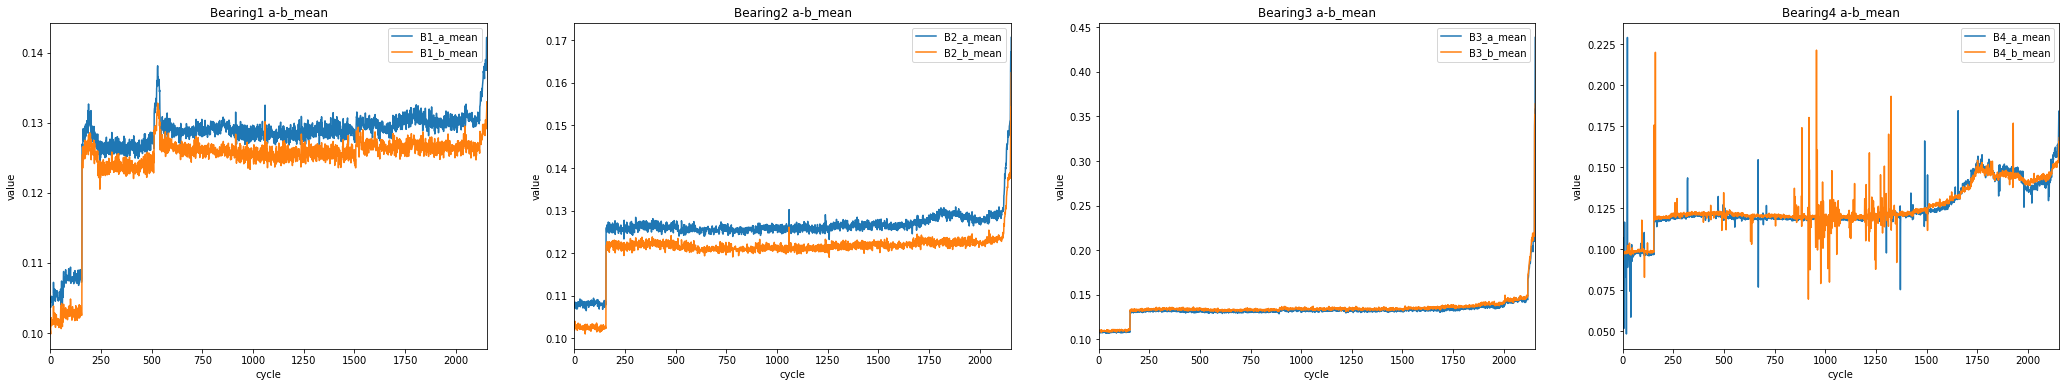

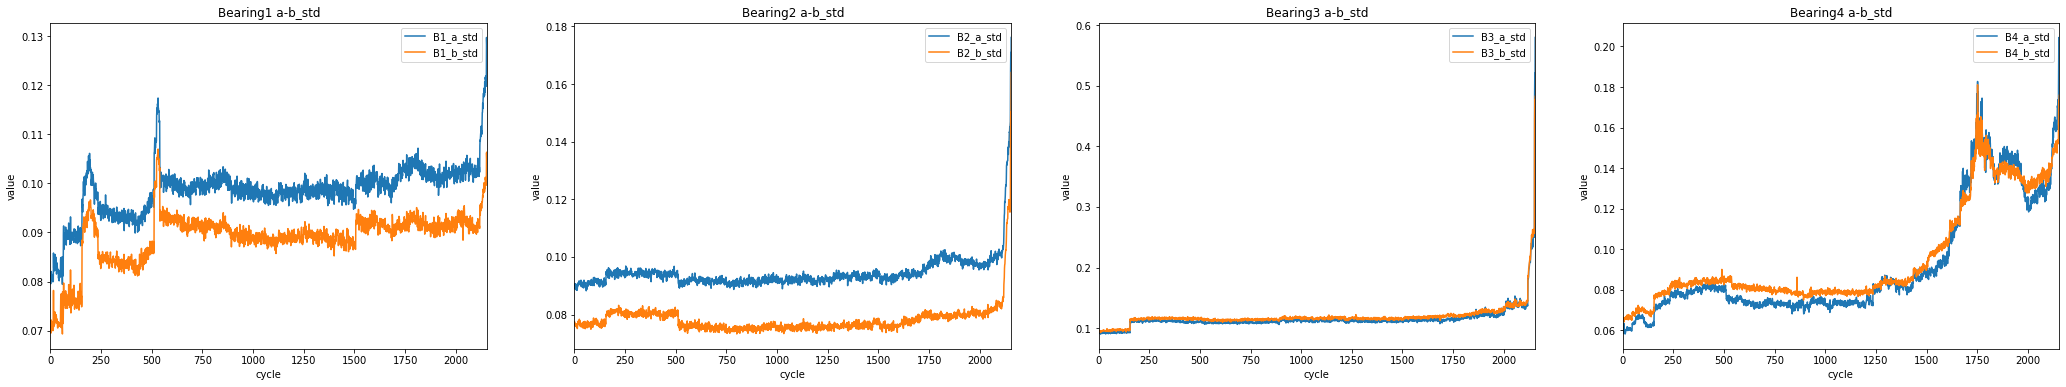

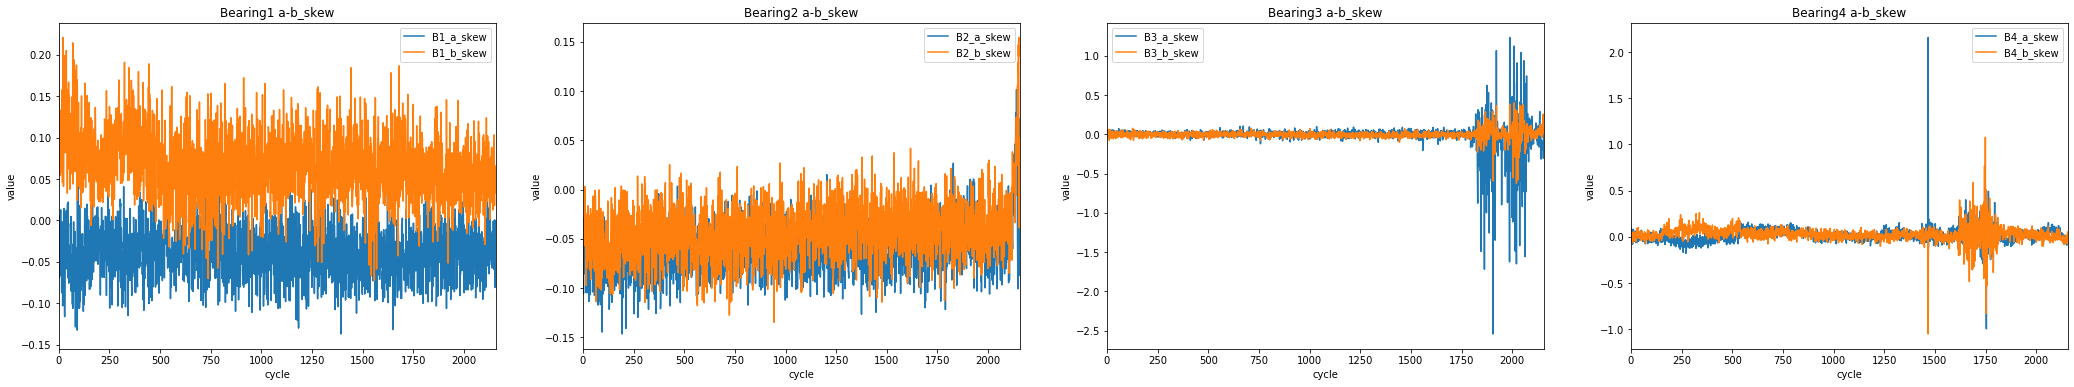

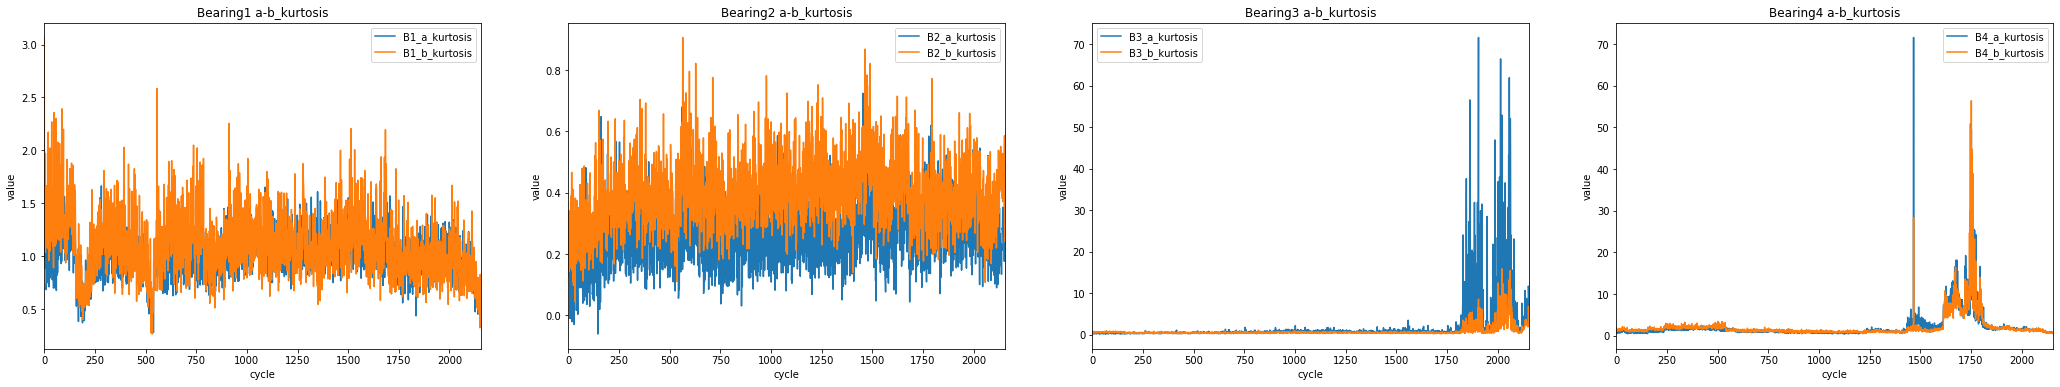

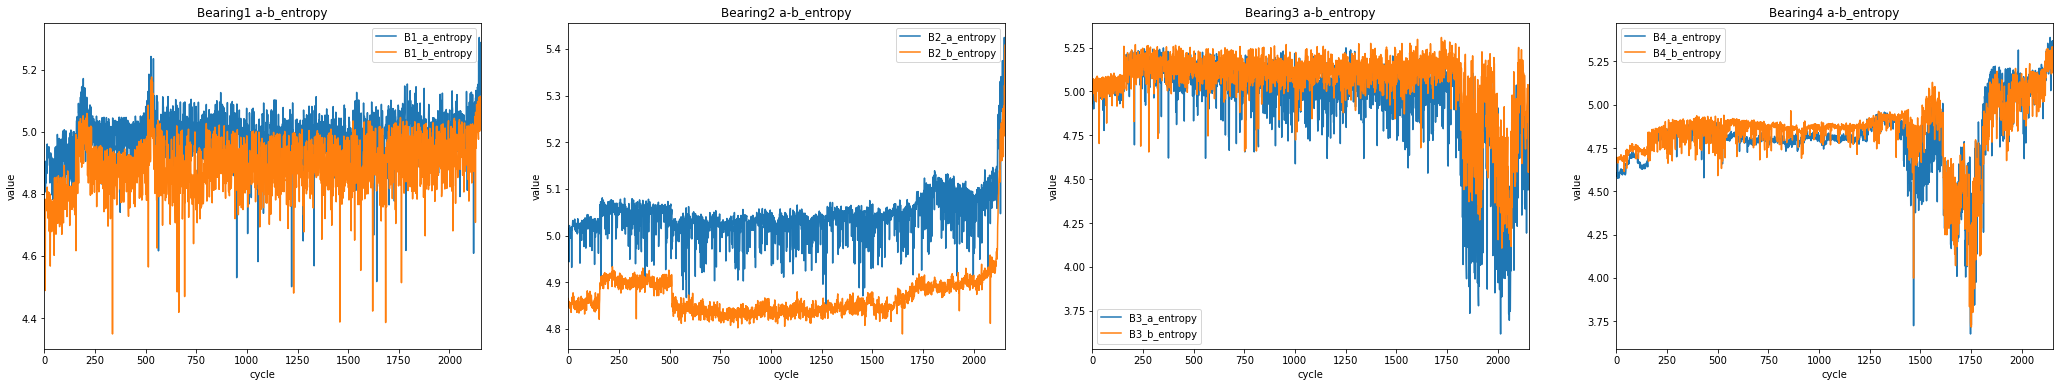

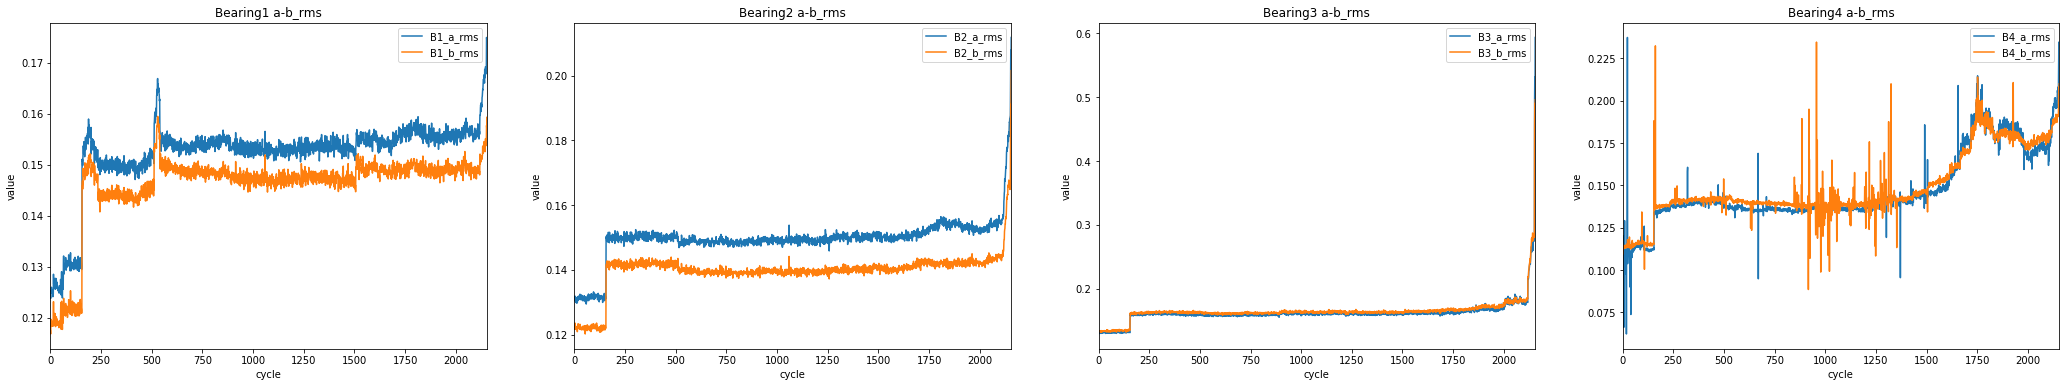

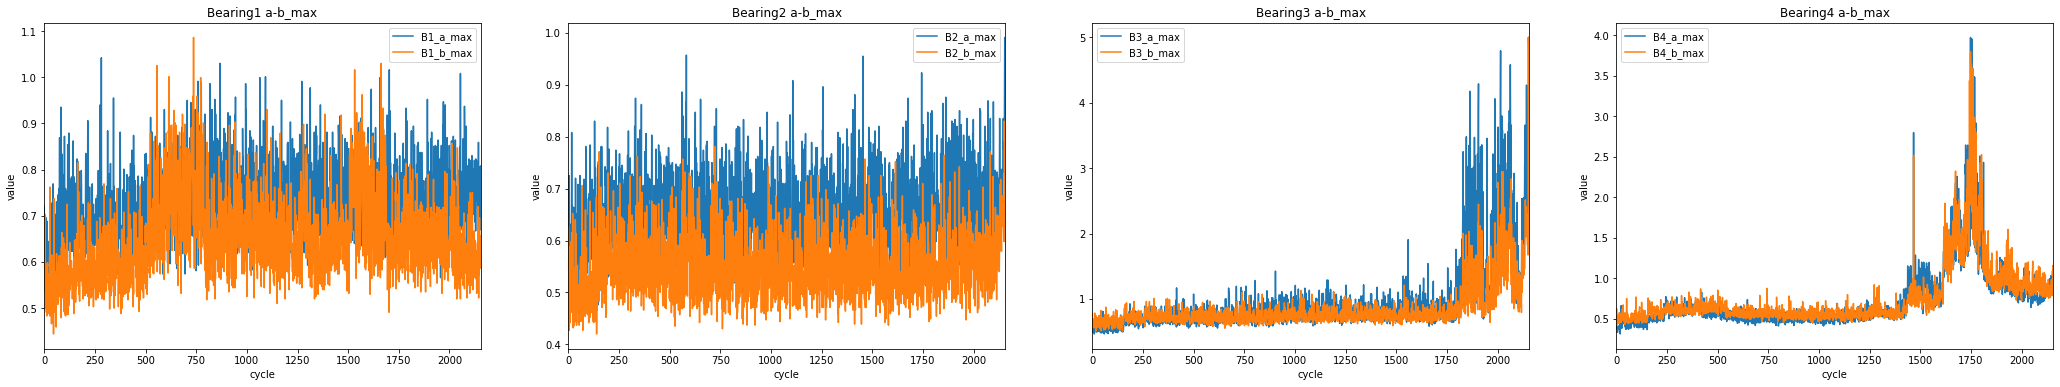

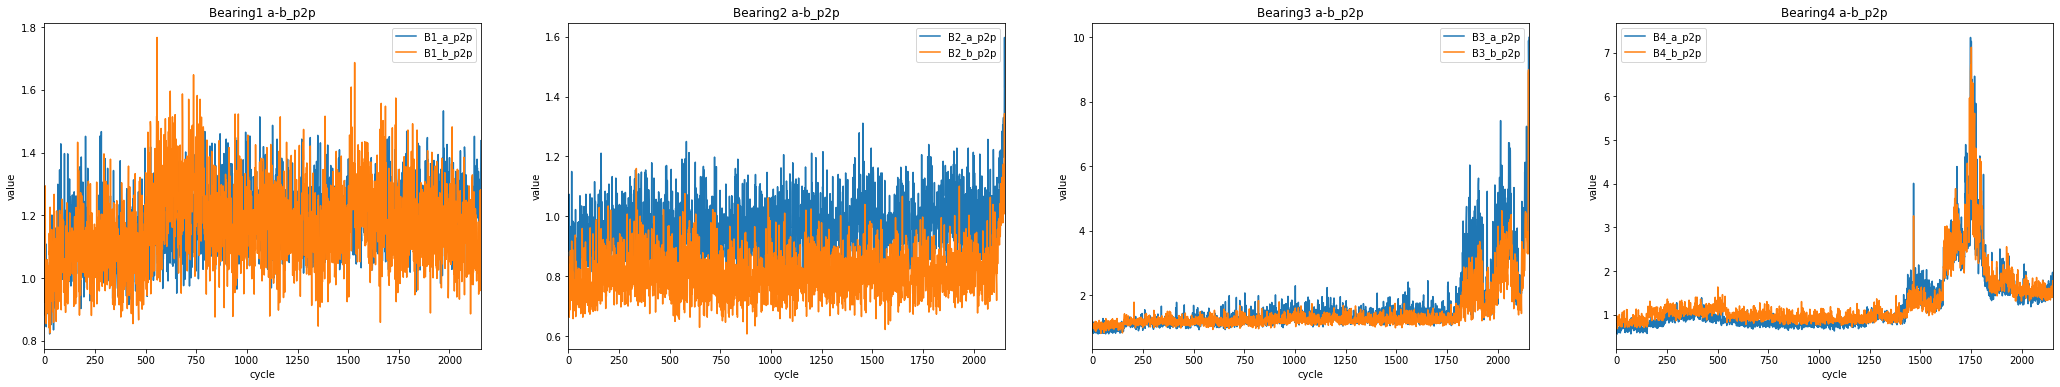

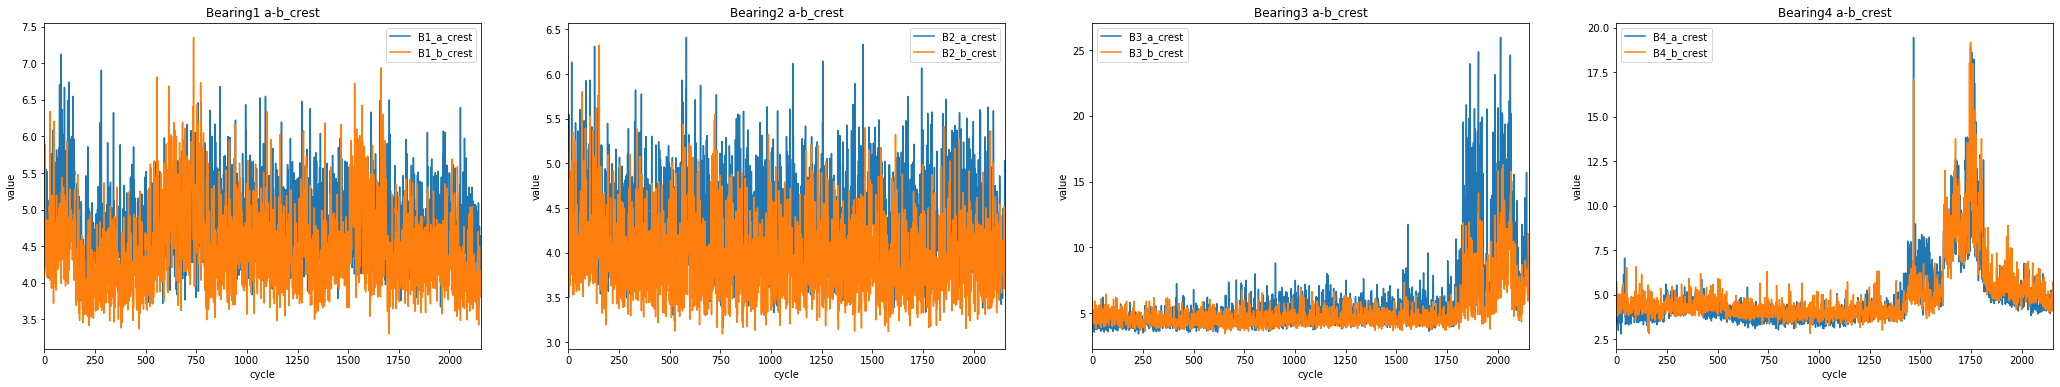

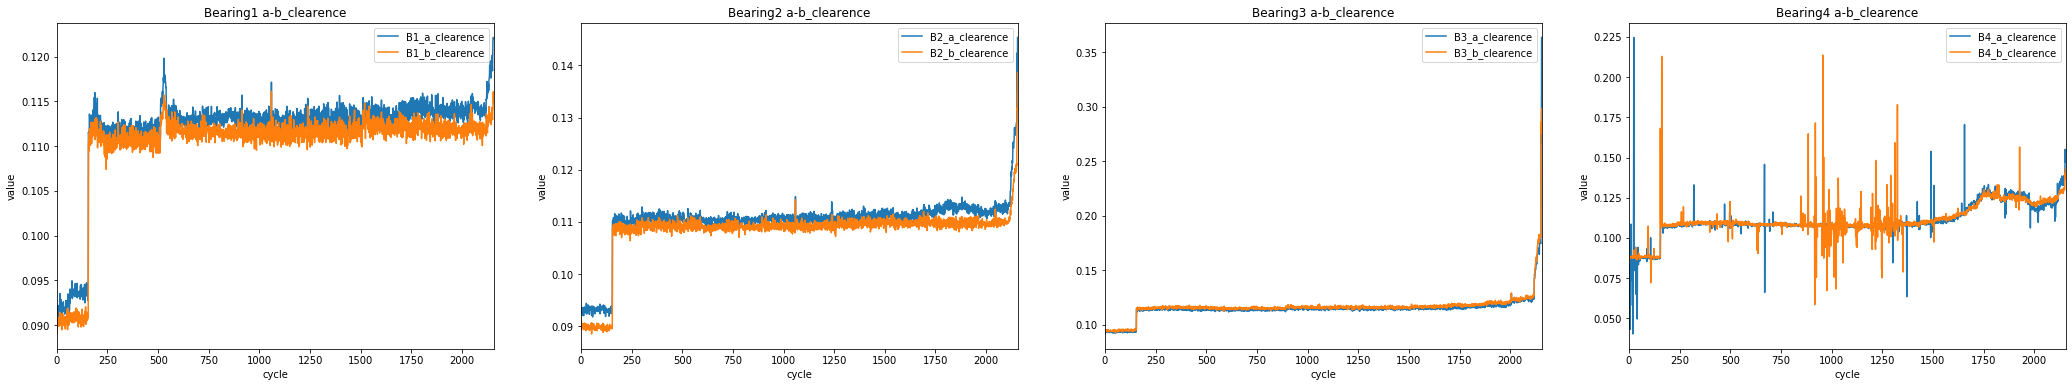

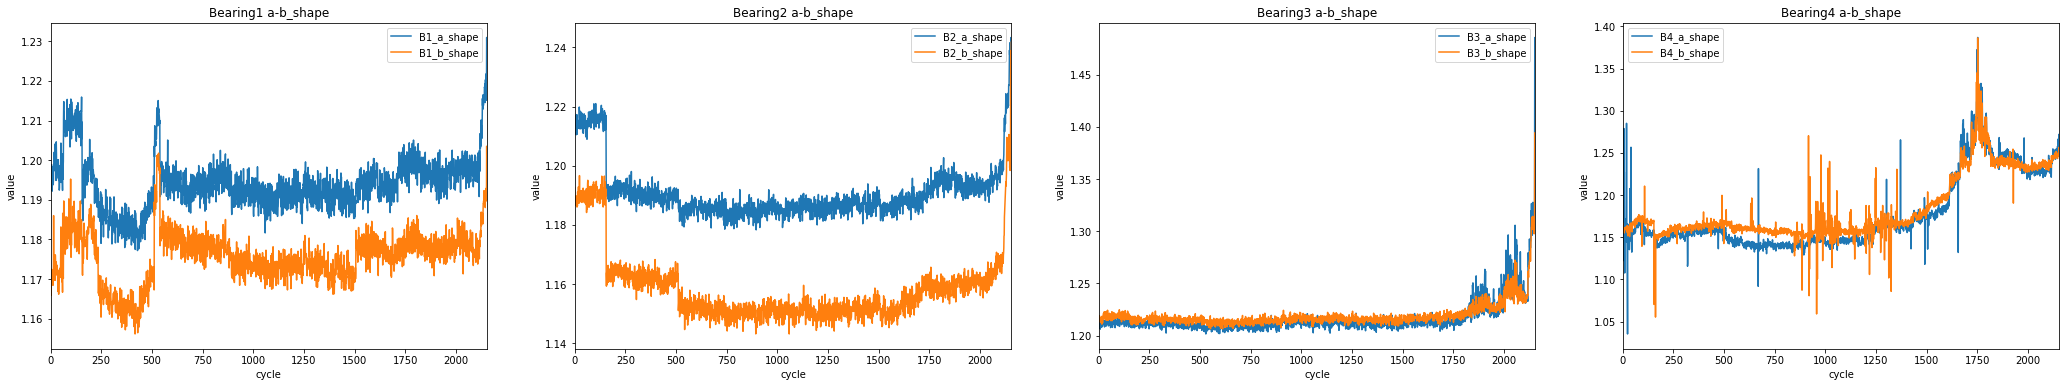

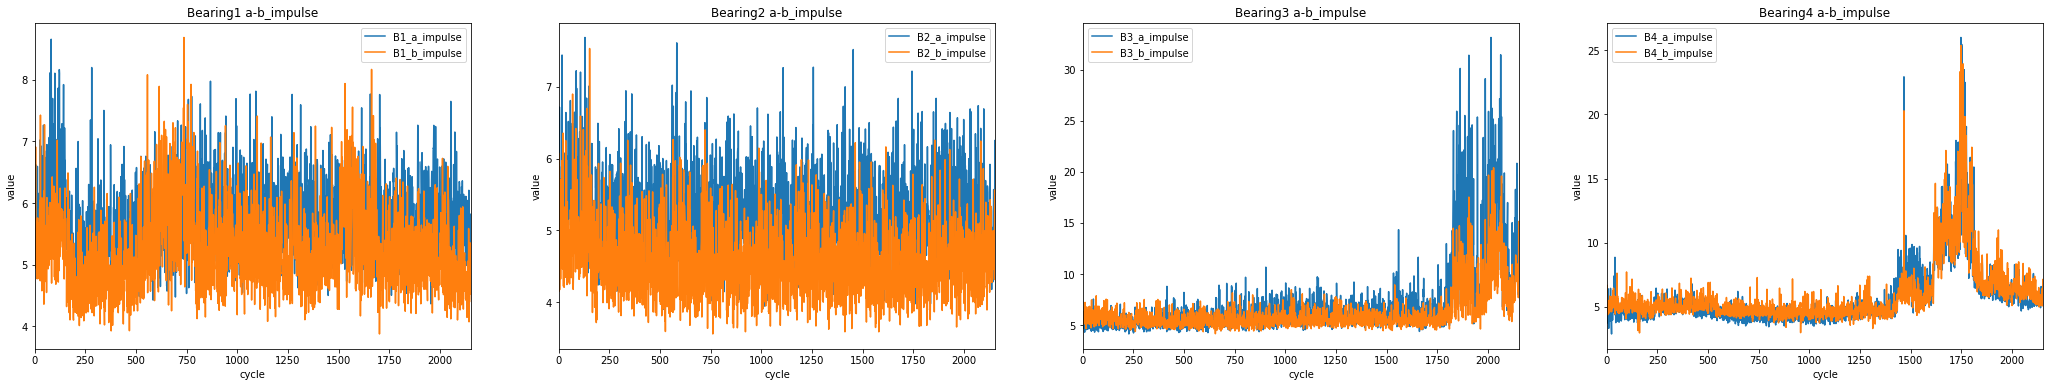

In [4]:
time_features_list = ["mean","std","skew","kurtosis","entropy","rms","max","p2p", "crest", "clearence", "shape", "impulse"]
bearings_ab = [["B"+str(n)+"_"+str(o)+"_" for n in range(1,5)] for o in ['a','b']]

for tf in time_features_list:
    fig = plt.figure()
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    
    axes = [ax1, ax2, ax3, ax4]
    
    for i in range(4):
        col = bearings_ab[0][i]+tf
        set1[col].plot(figsize = (36,6), title="Bearing{} a-b_".format(i+1)+tf , legend = True, ax=axes[i])
        col = bearings_ab[1][i]+tf
        set1[col].plot(figsize = (36,6) , legend = True, ax=axes[i])
        axes[i].set(xlabel="cycle", ylabel="value")

In [5]:
B1_state = list()
B2_state = list()
B3_state = list()
B4_state = list()
cnt = 0

for row in set1["time"]:
    cnt += 1
    # B1
    if cnt<=151:
        B1_state.append("early")
    if 151 < cnt <=600:
        B1_state.append("suspect")
    if 600 < cnt <=1499:
        B1_state.append("normal")
    if 1499 < cnt <=2098:
        B1_state.append("suspect")
    if 2098 < cnt <= 2156:
        B1_state.append("imminent_failure")
    #B2
    if cnt<=500:
        B2_state.append("early")
    if 500 < cnt <=2000:
        B2_state.append("normal")
    if 2000 < cnt <=2120:
        B2_state.append("suspect")
    if 2120< cnt <=2156:
        B2_state.append("imminet_failure")

    #B3
    if cnt<=500:
        B3_state.append("early")
    if 500 < cnt <= 1790:
        B3_state.append("normal")
    if 1790 < cnt <=2120:
        B3_state.append("suspect")
    if 2120 < cnt <=2156:
        B3_state.append("Inner_race_failure")
    #B4
    if cnt<=200:
        B4_state.append("early")
    if 200 < cnt <=1000:
        B4_state.append("normal")
    if 1000 < cnt <= 1435:
        B4_state.append("suspect")
    if 1435 < cnt <=1840:
        B4_state.append("Inner_race_failure")
    if 1840 < cnt <=2156:
        B4_state.append("Stage_two_failure")
#controlling the counts
from collections import Counter
print(Counter(B1_state))
print(Counter(B2_state))
print(Counter(B3_state))
print(Counter(B4_state))

set1["B1_state"] = B1_state
set1["B2_state"] = B2_state
set1["B3_state"] = B3_state
set1["B4_state"] = B4_state

set1

Counter({'suspect': 1048, 'normal': 899, 'early': 151, 'imminent_failure': 58})
Counter({'normal': 1500, 'early': 500, 'suspect': 120, 'imminet_failure': 36})
Counter({'normal': 1290, 'early': 500, 'suspect': 330, 'Inner_race_failure': 36})
Counter({'normal': 800, 'suspect': 435, 'Inner_race_failure': 405, 'Stage_two_failure': 316, 'early': 200})


time  B1_a_mean  B1_a_std  B1_a_skew  B1_a_kurtosis  \
0     2003-10-22 12:06:24   0.104148  0.081124  -0.029900       1.069800   
1     2003-10-22 12:09:13   0.103651  0.079519  -0.070118       1.161960   
2     2003-10-22 12:14:13   0.105039  0.080220  -0.041579       0.986724   
3     2003-10-22 12:19:13   0.104900  0.080828   0.005235       1.034758   
4     2003-10-22 12:24:13   0.104779  0.082038  -0.060123       1.110658   
...                   ...        ...       ...        ...            ...   
2151  2003-11-25 16:07:32   0.138784  0.120934   0.000689       0.477060   
2152  2003-11-25 23:13:21   0.142147  0.129748  -0.052217       0.555174   
2153  2003-11-25 23:19:56   0.142098  0.128376  -0.080830       0.383461   
2154  2003-11-25 23:29:56   0.141889  0.126898  -0.009047       0.515840   
2155  2003-11-25 23:39:56   0.142014  0.128898  -0.040078       0.557871   

      B1_a_entropy  B1_a_rms  B1_a_max  B1_a_p2p  B1_a_crest  ...  B4_b_max  \
0         4.802559  0.124617     0.720     1.108    5.777714  ...     0.471   
1         4.844846  0.123812     0.654     1.042    5.282223  ...     0.627   
2         4.889311  0.125249     0.623     0.940    4.974097  ...     0.601   
3         4.852691  0.125200     0.598     1.055    4.776357  ...     0.525   
4         4.889993  0.125621     0.623     1.011    4.959370  ...     0.522   
...            ...       ...       ...       ...         ...  ...       ...   
2151      5.204127  0.168642     0.669     1.145    3.966977  ...     0.786   
2152      5.191212  0.174977     0.803     1.316    4.589186  ...     0.908   
2153      5.283214  0.174572     0.710     1.159    4.067083  ...     0.911   
2154      5.249904  0.173459     0.776     1.298    4.473683  ...     1.157   
2155      5.121538  0.174185     0.808     1.438    4.638747  ...     0.889   

      B4_b_p2p  B4_b_crest  B4_b_clearence  B4_b_shape  B4_b_impulse  \
0        0.845    4.086202        0.089551    1.158299      4.733045   
1        0.900    5.741234        0.083762    1.166936      6.699653   
2        0.977    5.286066        0.088436    1.156631      6.114027   
3        0.852    4.588565        0.088515    1.160373      5.324447   
4        0.871    4.568532        0.088455    1.160343      5.301063   
...        ...         ...             ...         ...           ...   
2151     1.394    4.072505        0.131724    1.247509      5.080488   
2152     1.616    4.438966        0.138314    1.253199      5.562906   
2153     1.648    4.374943        0.140434    1.256528      5.497239   
2154     1.780    5.718411        0.136872    1.252521      7.162427   
2155     1.685    4.234688        0.142766    1.249191      5.289935   

              B1_state         B2_state            B3_state           B4_state  
0                early            early               early              early  
1                early            early               early              early  
2                early            early               early              early  
3                early            early               early              early  
4                early            early               early              early  
...                ...              ...                 ...                ...  
2151  imminent_failure  imminet_failure  Inner_race_failure  Stage_two_failure  
2152  imminent_failure  imminet_failure  Inner_race_failure  Stage_two_failure  
2153  imminent_failure  imminet_failure  Inner_race_failure  Stage_two_failure  
2154  imminent_failure  imminet_failure  Inner_race_failure  Stage_two_failure  
2155  imminent_failure  imminet_failure  Inner_race_failure  Stage_two_failure  

[2156 rows x 101 columns]

In [6]:
B1_cols = [col for col in set1.columns if "B1" in col]
B2_cols = [col for col in set1.columns if "B2" in col]
B3_cols = [col for col in set1.columns if "B3" in col]
B4_cols = [col for col in set1.columns if "B4" in col]

B1 = set1[B1_cols]
B2 = set1[B2_cols]
B3 = set1[B3_cols]
B4 = set1[B4_cols]
cols = ['Ba_mean','Ba_std','Ba_skew','Ba_kurtosis','Ba_entropy','Ba_rms','Ba_max','Ba_p2p','Ba_crest', 'Ba_clearence', 'Ba_shape', 'Ba_impulse',
        'Bb_mean','Bb_std','Bb_skew','Bb_kurtosis','Bb_entropy','Bb_rms','Bb_max','Bb_p2p','Bb_crest', 'Bb_clearence', 'Bb_shape', 'Bb_impulse',
        'class']
B1.columns = cols
B2.columns = cols
B3.columns = cols
B4.columns = cols
final_data = pd.concat([B1,B2,B3,B4], axis=0, ignore_index=True)
final_data

Ba_mean    Ba_std   Ba_skew  Ba_kurtosis  Ba_entropy    Ba_rms  Ba_max  \
0     0.104148  0.081124 -0.029900     1.069800    4.802559  0.124617   0.720   
1     0.103651  0.079519 -0.070118     1.161960    4.844846  0.123812   0.654   
2     0.105039  0.080220 -0.041579     0.986724    4.889311  0.125249   0.623   
3     0.104900  0.080828  0.005235     1.034758    4.852691  0.125200   0.598   
4     0.104779  0.082038 -0.060123     1.110658    4.889993  0.125621   0.623   
...        ...       ...       ...          ...         ...       ...     ...   
8619  0.165271  0.173055  0.008740     0.667410    5.368656  0.207456   0.908   
8620  0.175640  0.191118 -0.090755     0.635929    5.245199  0.222313   1.047   
8621  0.184356  0.204398 -0.079786     0.799410    5.289166  0.234520   1.091   
8622  0.174025  0.186758 -0.029800     0.581950    5.367520  0.219321   0.962   
8623  0.181261  0.197932 -0.018426     0.626349    5.353214  0.229178   1.030   

      Ba_p2p  Ba_crest  Ba_clearence  ...  Bb_kurtosis  Bb_entropy    Bb_rms  \
0      1.108  5.777714      0.090932  ...     3.067002    4.585195  0.117496   
1      1.042  5.282223      0.090784  ...     2.001592    4.674025  0.116834   
2      0.940  4.974097      0.092058  ...     1.969713    4.725061  0.118387   
3      1.055  4.776357      0.091833  ...     1.746190    4.750850  0.119007   
4      1.011  4.959370      0.091479  ...     1.182353    4.783104  0.119679   
...      ...       ...           ...  ...          ...         ...       ...   
8619   1.543  4.376832      0.140001  ...     0.671997    5.335049  0.193002   
8620   1.941  4.709571      0.148071  ...     0.514551    5.305560  0.204552   
8621   1.970  4.652059      0.155097  ...     0.537004    5.307928  0.208231   
8622   1.648  4.386256      0.147051  ...     0.563250    5.185493  0.202329   
8623   1.794  4.494313      0.152884  ...     0.584829    5.297237  0.209933   

      Bb_max  Bb_p2p  Bb_crest  Bb_clearence  Bb_shape  Bb_impulse  \
0      0.701   1.265  5.966175      0.089295  1.171995    6.992327   
1      0.581   1.072  4.972861      0.089011  1.170050    5.818495   
2      0.549   1.018  4.637340      0.090673  1.165883    5.406595   
3      0.535   1.009  4.495525      0.090402  1.171639    5.267131   
4      0.537   0.923  4.486993      0.090913  1.171246    5.255374   
...      ...     ...       ...           ...       ...         ...   
8619   0.786   1.394  4.072505      0.131724  1.247509    5.080488   
8620   0.908   1.616  4.438966      0.138314  1.253199    5.562906   
8621   0.911   1.648  4.374943      0.140434  1.256528    5.497239   
8622   1.157   1.780  5.718411      0.136872  1.252521    7.162427   
8623   0.889   1.685  4.234688      0.142766  1.249191    5.289935   

                  class  
0                 early  
1                 early  
2                 early  
3                 early  
4                 early  
...                 ...  
8619  Stage_two_failure  
8620  Stage_two_failure  
8621  Stage_two_failure  
8622  Stage_two_failure  
8623  Stage_two_failure  

[8624 rows x 25 columns]

In [7]:
a_axis_cols = ["Ba_"+tf for tf in time_features_list]
X = final_data.copy()
X_a = X.copy()
X_a = X[a_axis_cols]
cols = ['B_mean','B_std','B_skew','B_kurtosis','B_entropy',
        'B_rms','B_max','B_p2p','B_crest', 'B_clearence', 'B_shape', 'B_impulse']
X_a.columns = cols
y = X.pop("class")
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
X_a_train, X_a_test, y_train, y_test = train_test_split(X_a, y, test_size = 0.3, random_state =1)

In [8]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
    ]

for name, clf in zip(names,classifiers):
    print("training "+name+" ...")
    clf.fit(X_a_train,y_train)
    score = clf.score(X_a_test,y_test)
    print('Score of'+name+' is: '+str(score))
    #iterate over classifiers

training Nearest Neighbors ...
Score ofNearest Neighbors is: 0.7156105100463679
training Linear SVM ...
Score ofLinear SVM is: 0.5691653786707882
training RBF SVM ...
Score ofRBF SVM is: 0.7187017001545595
training Decision Tree ...
Score ofDecision Tree is: 0.7310664605873262
training Random Forest ...
Score ofRandom Forest is: 0.6846986089644513
training Neural Net ...
Score ofNeural Net is: 0.624420401854714
training AdaBoost ...
Score ofAdaBoost is: 0.597758887171561
training Naive Bayes ...
Score ofNaive Bayes is: 0.5467542503863988
training QDA ...


C:\Users\SWIFT 3\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Score ofQDA is: 0.6796754250386399


In [9]:
def objective(trial):
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 5, X_a_train.shape[1])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    model = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth, 
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    model.fit(X_a_train, y_train)
    preds = model.predict(X_a_test)
    accuracy_score(y_test, preds)
    return accuracy_score(y_test,preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-03-10 14:07:01,803] A new study created in memory with name: no-name-6d41cd6a-fc06-4fbf-845a-e8ea0b2a5a86
[I 2022-03-10 14:07:02,028] Trial 0 finished with value: 0.7534775888717156 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7534775888717156.
[I 2022-03-10 14:07:02,183] Trial 1 finished with value: 0.8114374034003091 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 15}. Best is trial 1 with value: 0.8114374034003091.
[I 2022-03-10 14:07:02,468] Trial 2 finished with value: 0.8210973724884081 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 19}. Best is trial 2 with value: 0.8210973724884081.
[I 2022-03-10 14:07:02,705] Trial 3 finished with value: 0.758500772797527 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 5}. Best is trial 2 

In [10]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 0.8218701700154559
Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 18}


In [11]:
final_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5, min_samples_leaf=4)
final_model.fit(X_a_train, y_train)
preds = final_model.predict(X_a_test)
accuracy_score(y_test, preds)

0.8272797527047914

In [12]:
set2 = pd.read_csv(r'C:\Users\SWIFT 3\Bearing Fault Detection\set2_timefeatures.csv')
set3 = pd.read_csv(r'C:\Users\SWIFT 3\Bearing Fault Detection\set3_timefeatures.csv')
time_2 = set2['Unnamed: 0']
#Setting index columns to time
set2 = set2.rename(columns={'Unnamed: 0':'time'}).set_index('time')
set3 = set3.rename(columns={'Unnamed: 0':'time'}).set_index('time')

In [13]:
B1_cols = [col for col in set2.columns if "B1" in col]
B2_cols = [col for col in set2.columns if "B2" in col]
B3_cols = [col for col in set2.columns if "B3" in col]
B4_cols = [col for col in set2.columns if "B4" in col]

set2_B1 = set2[B1_cols]
set2_B2 = set2[B2_cols]
set2_B3 = set2[B3_cols]
set2_B4 = set2[B4_cols]

cols = ['B_mean','B_std','B_skew','B_kurtosis','B_entropy','B_rms',
        'B_max','B_p2p','B_crest', 'B_clearence', 'B_shape', 'B_impulse']

set2_B1.columns = cols
set2_B2.columns = cols
set2_B3.columns = cols
set2_B4.columns = cols

In [14]:
B1_cols = [col for col in set3.columns if "B1" in col]
B2_cols = [col for col in set3.columns if "B2" in col]
B3_cols = [col for col in set3.columns if "B3" in col]
B4_cols = [col for col in set3.columns if "B4" in col]

set3_B1 = set3[B1_cols]
set3_B2 = set3[B2_cols]
set3_B3 = set3[B3_cols]
set3_B4 = set3[B4_cols]

cols = ['B_mean','B_std','B_skew','B_kurtosis','B_entropy','B_rms',
        'B_max','B_p2p','B_crest', 'B_clearence', 'B_shape', 'B_impulse']

set3_B1.columns = cols
set3_B2.columns = cols
set3_B3.columns = cols
set3_B4.columns = cols

In [16]:
# HERE number and dataset of bearing can be changed !!!
bearing = set2_B2

#predicting state of bearing with final_model
preds = final_model.predict(bearing)
preds = le.inverse_transform(preds)
#inserting prediction and time to the dataframe
bearing.insert(12,'state',preds)
bearing.insert(13, 'time',bearing.index)

for tf in time_features_list:
    col = "B_{}".format(tf)
    print(col)
    fig=go.Figure((go.Scatter(x=bearing['time'], y=bearing[col],
                             mode='lines',
                             line=dict(color='rgba(0,0,220,0.8)'))))
    fig.add_traces(px.scatter(bearing, x='time', y=col, color='state').data)
    fig.update_layout(template='plotly_dark')
    fig.update_xaxes(showgrid=False)
    fig.show()

B_mean


B_std


B_skew


B_kurtosis


B_entropy


B_rms


B_max


B_p2p


B_crest


B_clearence


B_shape


B_impulse
